In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [11]:
from lidar_clippin.model.sst import build_sst
from mmcv.runner import load_checkpoint
from lidar_clippin.model.sst import LidarEncoderSST
import pytorch_lightning as pl
import clip
import os


class LidarClippin(pl.LightningModule):
    def __init__(self, lidar_encoder: LidarEncoderSST, clip_model, batch_size: int):
        super().__init__()
        self.lidar_encoder = lidar_encoder
        self.clip = clip_model
        self.batch_size = batch_size
        for param in self.clip.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        image, point_cloud = batch
        with torch.no_grad():
            image_features = self.clip.encode_image(image)
        lidar_features = self.lidar_encoder(point_cloud)
        loss = F.mse_loss((image_features), (lidar_features))
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.lidar_encoder.parameters(), lr=1e-5)
        steps_per_epoch = (3618846//self.batch_size)//self.trainer.accumulate_grad_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=1e-3,
            #total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1,
            steps_per_epoch=steps_per_epoch,
            epochs=self.trainer.max_epochs,
        )
        scheduler = {"scheduler": scheduler, "interval" : "step"}
        return [optimizer], [scheduler]


clip_model, clip_preprocess = clip.load("ViT-B/32")
lidar_encoder = LidarEncoderSST("model/sst_encoder_only_config.py")
model = LidarClippin(lidar_encoder, clip_model, 1)
checkpoint_path = "wycby2lk/checkpoints/epoch=71-step=40680.ckpt"
checkpoint_path = "2ztxgqwf/checkpoints/epoch=37-step=12806.ckpt"
load_checkpoint(model, os.path.join("/proj/nlp4adas/users/x_geohe/lidar-clippin/lidar-clippin", checkpoint_path), map_location="cpu")
model.to(device)

Use load_from_local loader


LidarClippin(
  (lidar_encoder): LidarEncoderSST(
    (_sst): DynamicVoxelNet(
      (backbone): SSTv2(
        (block_list): ModuleList(
          (0): BasicShiftBlockV2(
            (encoder_list): ModuleList(
              (0): EncoderLayer(
                (win_attn): WindowAttention(
                  (self_attn): MultiheadAttention(
                    (out_proj): Linear(in_features=128, out_features=128, bias=True)
                  )
                )
                (linear1): Linear(in_features=128, out_features=256, bias=True)
                (dropout): Dropout(p=0, inplace=False)
                (linear2): Linear(in_features=256, out_features=128, bias=True)
                (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (dropout1): Dropout(p=0, inplace=False)
                (dropout2): Dropout(p=0, inplace=False)
              )
              (1): EncoderLayer(
  

In [3]:
from lidar_clippin.loader import build_loader

loader = build_loader("/proj/nlp4adas/datasets/once", clip_preprocess, batch_size=16, num_workers=2)

[Dataset] Found 4319007 frames.


In [12]:
images, lidars = next(iter(loader))

lidars = [lid .to(device) for lid in lidars]
images = [img.to(device) for img in images]

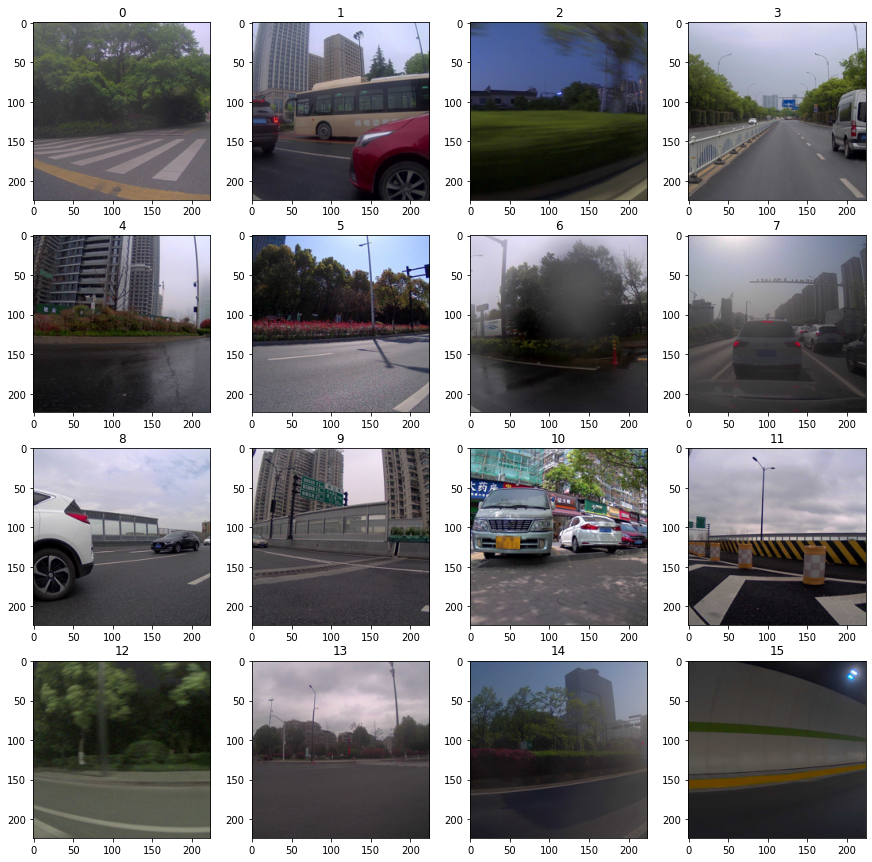

In [13]:
from einops import rearrange
from matplotlib import pyplot as plt
means = torch.tensor([0.48145466, 0.4578275, 0.40821073], device="cpu")
stds = torch.tensor([0.26862954, 0.26130258, 0.27577711], device="cpu")

fig, axs = plt.subplots(4,4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        idx = i*4 + j
        
        axs[i,j].imshow(rearrange(images[idx], "c h w -> h w c").cpu()*stds+means)
        axs[i,j].set_title(idx)

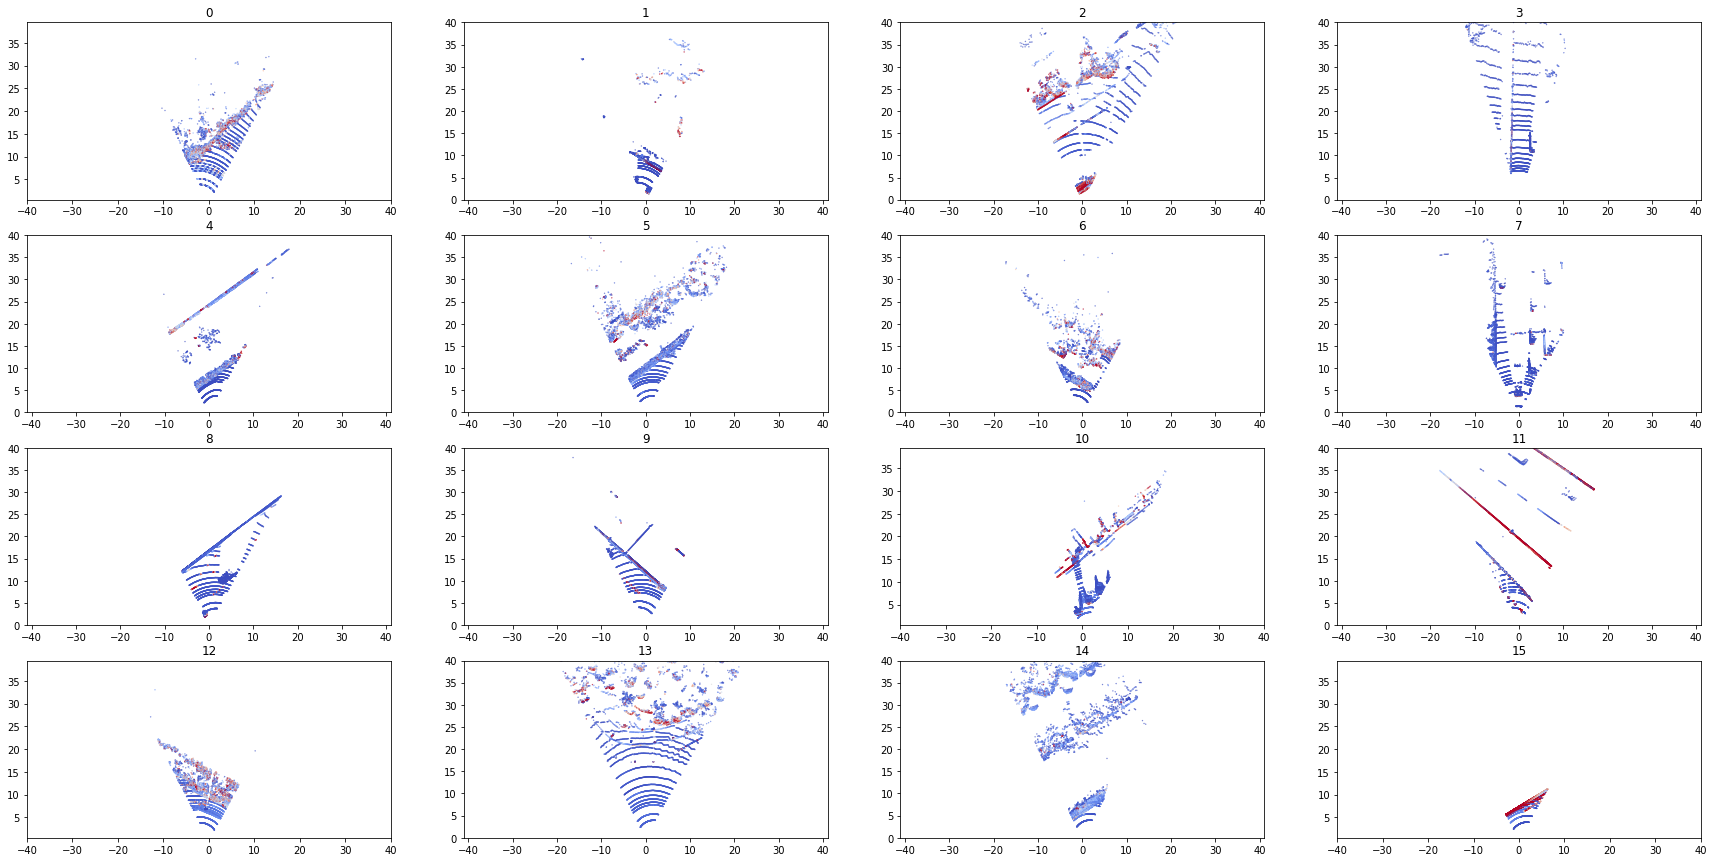

In [14]:
import numpy as np
fig, axs = plt.subplots(4,4, figsize=(30, 15))
for i in range(4):
    for j in range(4):
        idx = i*4 + j
        pc = lidars[idx].cpu()
        axs[i,j].scatter(-pc[:,1], pc[:,0], s=0.1, c=np.clip(pc[:, 3], 0, 1), cmap="coolwarm")
        axs[i,j].axis("equal")
        axs[i,j].set_xlim(-40, 40)
        axs[i,j].set_ylim(0, 40)
        axs[i,j].set_title(idx)

plt.show()

In [15]:
out = model.lidar_encoder(lidars).float()

drop_info is set to {0: {'max_tokens': 30, 'drop_range': (0, 30)}, 1: {'max_tokens': 60, 'drop_range': (30, 60)}, 2: {'max_tokens': 100, 'drop_range': (60, 100)}, 3: {'max_tokens': 200, 'drop_range': (100, 200)}, 4: {'max_tokens': 250, 'drop_range': (200, 100000)}}, in input_layer
No voxel belongs to drop_level:4 in shift 0


In [16]:
torch.save(out, 'lidar_out.pt')

In [ ]:
# Encode some text
text = clip.tokenize(["a car", "a bus", "a truck", "a person", "a construction vehicle", "a tree", "a bush"]).to(device)
#text = clip.tokenize(["a rural road", "a urban road", "a highway", "an overhead bridge", "a cross-walk"]).to(device)
#text = clip.tokenize(["an image at night", "an image during the day"]).to(device)
#text = clip.tokenize(["a road with cars", "an empty road"]).to(device)
#text = clip.tokenize(["a tiny car", "a small car", "a normal-size car", "a big car", "a huge car"]).to(device)
#text = clip.tokenize(["a white car", "a black car", "a red car", "a green car", "a blue car", "a yellow car"]).to(device)
#text = clip.tokenize(["a cross-walk", "an empty road", "a crossing"]).to(device)
#text = clip.tokenize(["a wet road", "a dry road"]).to(device)
#text = clip.tokenize(["the front of a car", "the back of a car", "the side of a car"]).to(device)
text = clip.tokenize(["a photo of a car in traffic", "a photo of a person in traffic", "a photo of a bike in traffic", "a photo of an empty road"]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text)


In [ ]:
# Lidar logits
logits_per_text, logits_per_image = logit_img_txt(out, text_features, clip_model)
#print(logits_per_text)
print(logits_per_text.softmax(0).T)
print(logits_per_image)
print(logits_per_image.softmax(0))
print("*"*20)

# Image logits
logits_per_text, logits_per_image = logit_img_txt(clip_model.encode_image(torch.cat([i.unsqueeze(0) for i in images])), text_features, clip_model)
#print(logits_per_text)
print(logits_per_text.softmax(0).T)
print(logits_per_image)
print(logits_per_image.softmax(0))

In [ ]:
import os
import random
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

max_num_seq = 1000
model, preprocess = clip.load("ViT-B/32", device=device)

data_path = "/proj/nlp4adas/datasets/once/data/"
sequences = os.listdir(data_path)
image_feat = dict()
i = 0
for seq in sequences:
    seq_path = os.path.join(data_path, seq, "cam01")
    if not "cam01" in os.listdir(os.path.join(data_path, seq)):
        continue
    if i == max_num_seq:
        break

    imgs = os.listdir(seq_path)
    random.shuffle(imgs)
    j = 0
    for img in imgs:
        if j == 10:
            break
        image_path = os.path.join(seq_path, img)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            image_feat[image_path] = image_features
        j += 1
    i += 1



In [ ]:
text = clip.tokenize(["a crowded cross-walk"]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)

In [ ]:
def logit_img_txt(img_feat, txt_feat, model):
    img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logit_scale = model.logit_scale.exp().float()
    logits_per_image = logit_scale * img_feat.float() @ txt_feat.t().float()
    logits_per_text = logits_per_image.t()
    return logits_per_text, logits_per_image

In [ ]:
image_feat_tensor = torch.cat([img_feat for img_feat in image_feat.values()])

logits_per_text, logits_per_image = logit_img_txt(image_feat_tensor, text_features, model)

In [ ]:
logits_per_image[logits_per_image.argmax()]

In [ ]:
list(image_feat.keys())[logits_per_image.argmax()]

In [ ]:
top_imgs_idx = torch.topk(logits_per_image.squeeze(), 5)
for idx in top_imgs_idx[1]:
    img = list(image_feat.keys())[idx]
    img = Image.open(img)
    img.show()

In [ ]:
top_imgs_idx = torch.topk(-logits_per_image.squeeze(), 5)
for idx in top_imgs_idx[1]:
    img = list(image_feat.keys())[idx]
    img = Image.open(img)
    img.show()